# Index - Mortality


### 1) Importing the required packages

In [7]:
%run ./functions.ipynb

import pandas as pd
import numpy as np 
import pandas_datareader
from pandas_datareader import wb
from fancyimpute import KNN, SoftImpute, IterativeImputer, BiScaler, NuclearNormMinimization, IterativeSVD  
from sklearn import preprocessing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pmdarima as pm
import typing
import random
random.seed(2020)

### 2) Download the data

In [8]:
area = "Mortality" #set the indicator area
area2 = "Mortality" 

worldbank_data, tickers = load_the_database(area = area)

### 3) Area-specific data transformation

In [11]:
worldbank_data["SP.POP.TOTL"]

country      year
Afghanistan  2019           NaN
             2018    37172386.0
             2017    36296400.0
             2016    35383128.0
             2015    34413603.0
                        ...    
Zimbabwe     1994    11261744.0
             1993    11092766.0
             1992    10900502.0
             1991    10680995.0
             1990    10432421.0
Name: SP.POP.TOTL, Length: 5490, dtype: float64

In [12]:
worldbank_data["VC.BTL.DETH"] = worldbank_data["VC.BTL.DETH"]/worldbank_data["SP.POP.TOTL"]
worldbank_data = worldbank_data.drop(["SP.POP.TOTL"],1)

In [13]:
tickers_ = tickers[["Indicator ticker", "Transformation 1", "Transformation 2", "Scaling / Normalisation", "bounds", "symmetric value"]]

#inverse
inverse = tickers[tickers["Transformation 2"] == "inverse"]
inv = worldbank_data.columns[worldbank_data.columns.isin(inverse["Indicator ticker"])]
#worldbank_data[inv] = 1/(worldbank_data[inv] +0.02)
#worldbank_data[inv][worldbank_data > 50] = 50

worldbank_data[inv] = -worldbank_data[inv]


#bounded percentile
bounds_percentile = tickers[tickers["Scaling / Normalisation"] == "bounds_percentile"]
bounds = worldbank_data.columns[worldbank_data.columns.isin(bounds_percentile["Indicator ticker"])]

for col in bounds:
    percentiles = worldbank_data[col].groupby(level = 1).quantile([0.02,0.98]).values
    worldbank_data[col] = np.clip(worldbank_data[col], percentiles[0], percentiles[1])
    
#symmetric

symmetric = tickers[tickers["Scaling / Normalisation"] == "symmetric"]
sym = worldbank_data.columns[worldbank_data.columns.isin(symmetric["Indicator ticker"])]
worldbank_data[sym] = -(1 - worldbank_data[sym]).abs()

## Check the correlations

In [17]:
#remove unnecessary variables to avoid very high correlation
worldbank_data = worldbank_data.drop(["SH.DYN.MORT.MA", "SH.DYN.MORT.FE","SH.DYN.MORT"], axis = 1)

KeyError: "['SH.DYN.MORT.MA' 'SH.DYN.MORT.FE'] not found in axis"

In [19]:
import seaborn as sb

corr_matrix = worldbank_data.corr()


#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
               
sol[sol >0.80]

SH.DYN.NMRT     SP.DYN.IMRT.IN    0.956176
SP.DYN.LE00.IN  SP.DYN.IMRT.IN    0.937347
                SH.DTH.COMM.ZS    0.927249
SH.STA.MMRT     SH.STA.WASH.P5    0.913023
SP.DYN.IMRT.IN  SH.DTH.COMM.ZS    0.903114
                SH.STA.WASH.P5    0.895603
SP.DYN.LE00.IN  SH.DYN.NMRT       0.886378
SH.STA.WASH.P5  SH.DTH.COMM.ZS    0.885305
SH.STA.MMRT     SP.DYN.IMRT.IN    0.884333
SP.DYN.LE00.IN  SH.STA.AIRP.P5    0.881164
                SH.STA.WASH.P5    0.878716
SH.DYN.NMRT     SH.DTH.COMM.ZS    0.878620
SP.DYN.IMRT.IN  SH.STA.AIRP.P5    0.875614
SH.DYN.NMRT     SH.STA.AIRP.P5    0.860423
SP.DYN.LE00.IN  SH.STA.MMRT       0.851950
SH.STA.WASH.P5  SH.STA.POIS.P5    0.845518
SH.STA.MMRT     SH.DYN.NMRT       0.839470
                SH.DTH.COMM.ZS    0.836759
SH.DYN.NMRT     SH.STA.WASH.P5    0.822004
SH.STA.MMRT     SH.STA.AIRP.P5    0.811866
SH.STA.AIRP.P5  SH.DTH.COMM.ZS    0.804598
dtype: float64

In [20]:
worldbank_data_idx = worldbank_data.copy().reset_index()

### 4) Imputing the missing data


In [21]:
worldbank_data_filled = impute_missing()

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\sklearn\impute\_iterative.py:638: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



### 5) Scaling and forecasting the data

In [22]:
worldbank_data_scaled = scale_and_forecast()

worldbank_data_scaled = worldbank_data_scaled.reset_index()
worldbank_data_scaled = worldbank_data_scaled.drop_duplicates(subset=['country', 'year'], keep='last')
worldbank_data_scaled.set_index(["country", "year"], inplace =True )
worldbank_data_scaled = worldbank_data_scaled.where(worldbank_data_scaled < 1, 1)

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. C

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Bebezi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed t

### 6) Build the index (mean, median, pca...)

In [23]:
#Taking the mean to build our indicator
worldbank_data_scaled["indicator"] = worldbank_data_scaled.mean(axis=1)

#IC1_ = IC1.set_index(["country", "year"])
#IC2_ = IC2.set_index(["country", "year"])

#IC1_["ic1"] = IC1_.mean(axis = 1)
#IC1_ = IC1_[["ic1"]]

#IC2_["ic2"] = IC2_.mean(axis = 1)
#IC2_ = IC2_[["ic2"]]


#worldbank_data_scaled_IC = worldbank_data_scaled.join(IC1_)
#worldbank_data_scaled_IC = worldbank_data_scaled_IC.join(IC2_)

#Or Median
#worldbank_data_scaled["indicator"] = worldbank_data_scaled.median(axis=1)

#Or it can be done by using PCA 

#from sklearn.decomposition import PCA
#pca = PCA(n_components = "mle")
#pca_fit = pca.fit_transform(worldbank_data_scaled)
#expvar = pca.explained_variance_ratio_[np.cumsum(pca.explained_variance_ratio_) < 0.90001]
#leng = len(expvar)
#pca_fit = pd.DataFrame(pca_fit).iloc[:, : leng]
#pca_fit = -pca_fit
#pca_fit = pca_fit*expvar
#indicator = pca_fit.sum(axis = 1)
#indicator = (indicator - indicator.min(axis=0)) / (indicator.max(axis=0) - indicator.min(axis=0))
#
#worldbank_data_scaled.reset_index(inplace = True)
#worldbank_data_scaled["indicator"] = indicator





worldbank_data_scaled.reset_index(inplace = True)
worldbank_data_scaled.year = worldbank_data_scaled.year.astype(int)
merged_data = worldbank_data_scaled
std = pd.DataFrame(merged_data.groupby('country')["indicator"].std())
std = std.rename({'indicator': 'std'}, axis = "columns")
merged_data = pd.merge(merged_data, std, on = "country")
merged_data["ic1"] = (merged_data["indicator"] - merged_data["std"]) - (merged_data["year"]-2019)/100
merged_data["ic2"] =  (merged_data["indicator"] + merged_data["std"]) + (merged_data["year"]-2019)/100
merged_data["ic1"] = np.where(merged_data["year"] > 2019, merged_data["ic1"], "")
merged_data["ic2"] = np.where(merged_data["year"] > 2019, merged_data["ic2"], "")
merged_data[merged_data["year"] == 2019].nlargest(10, 'indicator')

,country,year,SP.DYN.LE00.IN,SH.STA.MMRT,SH.DYN.NMRT,SP.DYN.IMRT.IN,SH.STA.SUIC.P5,SH.STA.WASH.P5,SH.STA.POIS.P5,SH.STA.AIRP.P5,SH.DTH.COMM.ZS,SH.DYN.NCOM.ZS,SH.STA.TRAF.P5,VC.BTL.DETH,VC.IHR.PSRC.P5,indicator,std,ic1,ic2
1785,Spain,2019,0.671171,0.322741,0.635634,0.464613,0.612123,0.333278,0.598605,0.811810,0.678825,0.995368,0.994997,0.608068,0.673567,0.646215,0.134656,,
1470,Germany,2019,0.660785,0.329178,0.646656,0.474220,0.246735,0.346160,0.654419,0.784113,0.687540,0.957992,0.993985,0.892087,0.662388,0.641251,0.098397,,
2800,Italy,2019,0.675110,0.323126,0.626855,0.464768,0.633631,0.333978,0.536608,0.821958,0.708383,0.997357,0.951048,0.578591,0.630535,0.637073,0.146372,,
3815,Malta,2019,0.678347,0.319177,0.590965,0.460163,0.690522,0.342005,0.628637,0.767754,0.634352,0.985135,0.941876,0.586981,0.642632,0.636042,0.132080,,
1400,Cyprus,2019,0.675048,0.321094,0.626114,0.462921,0.928498,0.342030,0.636942,0.763032,0.697859,0.979277,0.971000,0.159109,0.682930,0.634297,0.135657,,
4270,Netherlands,2019,0.670974,0.317053,0.632319,0.464721,0.419162,0.335427,0.660825,0.769227,0.631099,0.968948,0.986844,0.635992,0.683691,0.628945,0.155625,,
2030,United Kingdom,2019,0.663905,0.314989,0.632346,0.462825,0.578417,0.326089,0.547056,0.758562,0.559510,0.968602,0.993432,0.706112,0.649953,0.627831,0.154770,,
2765,Israel,2019,0.672764,0.318392,0.627408,0.460248,0.692682,0.330393,0.599768,0.815815,0.586164,0.995331,0.997692,0.479479,0.554294,0.625418,0.146714,,
4725,Qatar,2019,0.685688,0.319517,0.582711,0.440109,0.861922,0.336709,0.577770,0.632543,0.634716,0.887061,0.723559,0.633852,0.740204,0.619720,0.126182,,
210,Australia,2019,0.674099,0.319046,0.639387,0.466606,0.297255,0.327256,0.602150,0.853902,0.696239,0.998795,0.957817,0.583456,0.621092,0.618238,0.112761,,


In [24]:
merged_data[merged_data["year"] == 2019].nlargest(10, 'indicator')[["country", "indicator"]]

,country,indicator
1785,Spain,0.646215
1470,Germany,0.641251
2800,Italy,0.637073
3815,Malta,0.636042
1400,Cyprus,0.634297
4270,Netherlands,0.628945
2030,United Kingdom,0.627831
2765,Israel,0.625418
4725,Qatar,0.619720
210,Australia,0.618238


In [25]:
merged_data[merged_data["year"] == 2019]["indicator"]

0       0.345554
35      0.436799
70      0.595664
105     0.573833
140     0.548163
          ...   
6230    0.473190
6265    0.371506
6300    0.402107
6335    0.445862
6370    0.383027
Name: indicator, Length: 183, dtype: float64

### 7) Plot the indicator for each country

In [26]:
plot_variable()

C:\Users\Bebezi\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 8) Export to a Csv File

In [27]:
merged_data.to_csv(area + "_index.csv")

In [28]:
coucodes = pd.read_csv("coucodes.csv", sep = ";", encoding='cp1252')
merged_data = pd.merge(merged_data, coucodes, left_on = "country", right_on = "Country Name WB")
merged_data = merged_data[merged_data["year"] == 2019]
merged_data.set_index("ISO Code", inplace = True)


cm = plt.get_cmap('Greens')
num_colors = 9
values = np.asarray(merged_data["indicator"], dtype='float64')
bins = np.linspace(values.min(), values.max(), num_colors)
merged_data['bin'] = np.digitize(values, bins) - 1
scheme = [cm(i / num_colors) for i in range(num_colors)]

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl

shapefile = 'ne_10m_admin_0_countries'
cols = ['country', 'ISO Code', "indicator"]


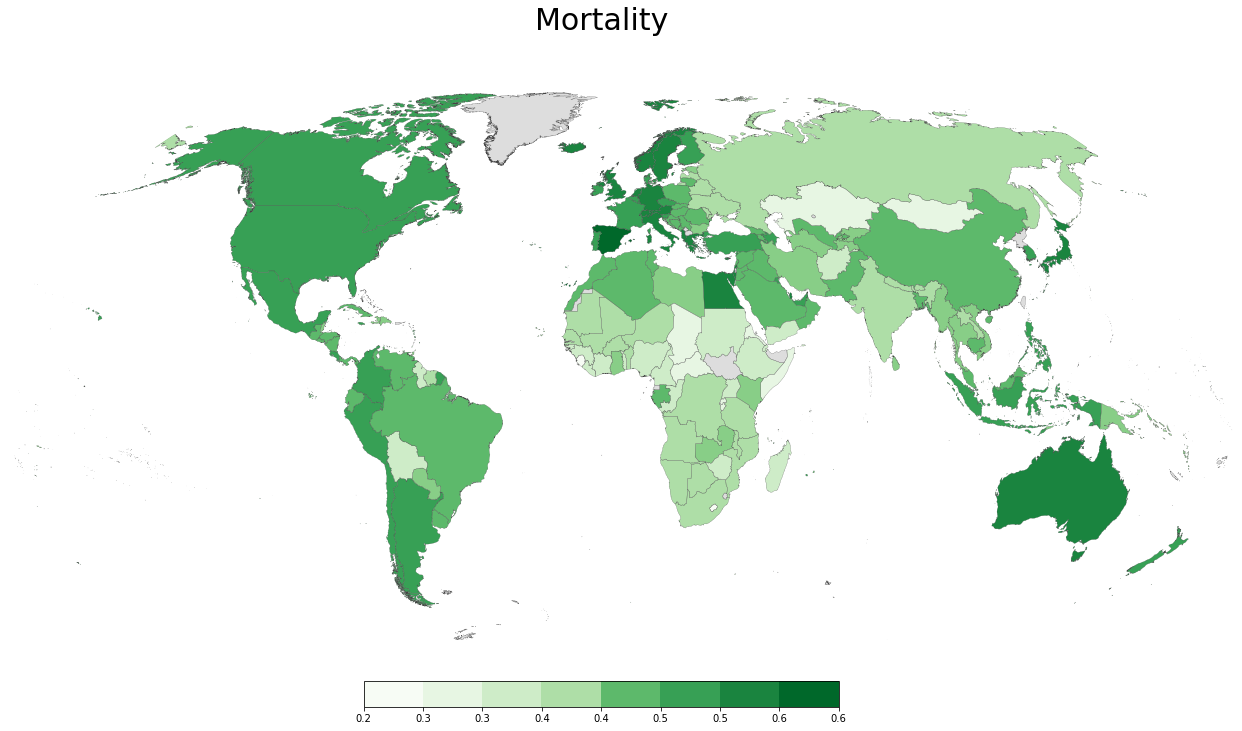

In [29]:
fig = plt.figure(figsize=(22, 12))

ax = fig.add_subplot(111, facecolor='w', frame_on=False)
fig.suptitle(area2, fontsize=30, y=.95)

m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='w')

m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
for info, shape in zip(m.units_info, m.units):
    iso3 = info['ADM0_A3']
    if iso3 not in merged_data.index:
        color = '#dddddd'
    else:
        color = scheme[merged_data.loc[iso3]['bin']]

    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)

# Cover up Antarctica so legend can be placed over it.
ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

# Draw color legend.
ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

# Set the map footer.
#plt.annotate(description, xy=(-.8, -3.2), size=14, xycoords='axes fraction')
plt.savefig('education_map.png')

